Coronavirus tweets NLP Dataset contains 6 columns, each are:

id
created_at
source
original_text:  Twitter Text
lang
favorite_count
retweet_count
original_author: Name
hashtags
user_mentions
place: Tweeted from
clean_tweet
compound
neg
neu
pos
sentiment: Label

UserName: Name
ScreenName: Screen Name
Location: Tweeted from
TweetAt: Tweeted At
OriginalTweet: Twitter Text
Sentiment: Label

## 📊EDA on each columns

## 📃 Tweets Analysis (contains 3 parts: unigram, hashtags & mentions, each sentiments)

## 🗂Text Clustering using kmeans and PCA

In [ ]:
# For Data
import pandas as pd
import numpy as np

#  For Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import missingno as msno
from wordcloud import WordCloud

# For NLP
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


# For Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

# For Styling
plt.style.use('default')

In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/final/archive/"

file_list = [
    "Covid-19 Twitter Dataset (Apr-Jun 2020).csv",
    "Covid-19 Twitter Dataset (Apr-Jun 2021).csv",
    "Covid-19 Twitter Dataset (Aug-Sep 2020).csv"
]

# file_list = [
    # "Covid-19 Twitter Dataset (Apr-Jun 2020).csv"
# ]

# 使用一行程式碼讀取並合併所有 CSV 文件
df = pd.concat([pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/final/archive/{file}') for file in file_list])

df['created_at'] = pd.to_datetime(df['created_at'])
df['length'] = df['original_text'].apply(lambda x: len(str(x)) if isinstance(x, (str, float)) and not pd.isna(x) else 0)

# df.drop(['id'],axis=1, inplace=True)
## to save memory
df = df.reset_index(drop=True)
df = df[['clean_tweet', 'place', 'created_at', 'sentiment', 'length']]


# df = df[['index','original_text', 'palace', 'created_at', 'sentiment', 'length']]

df.head(2)

clean_tweet                   place  \
0  call leader help protect refuge covid19 provid...  Jakarta Capital Region   
1  ogun state support cbn nirsal covid19 target c...                 Nigeria   

  created_at sentiment  length  
0 2020-04-19       pos     139  
1 2020-04-19       pos     116

Text(0.5, 1.0, 'Missing values of each columns')

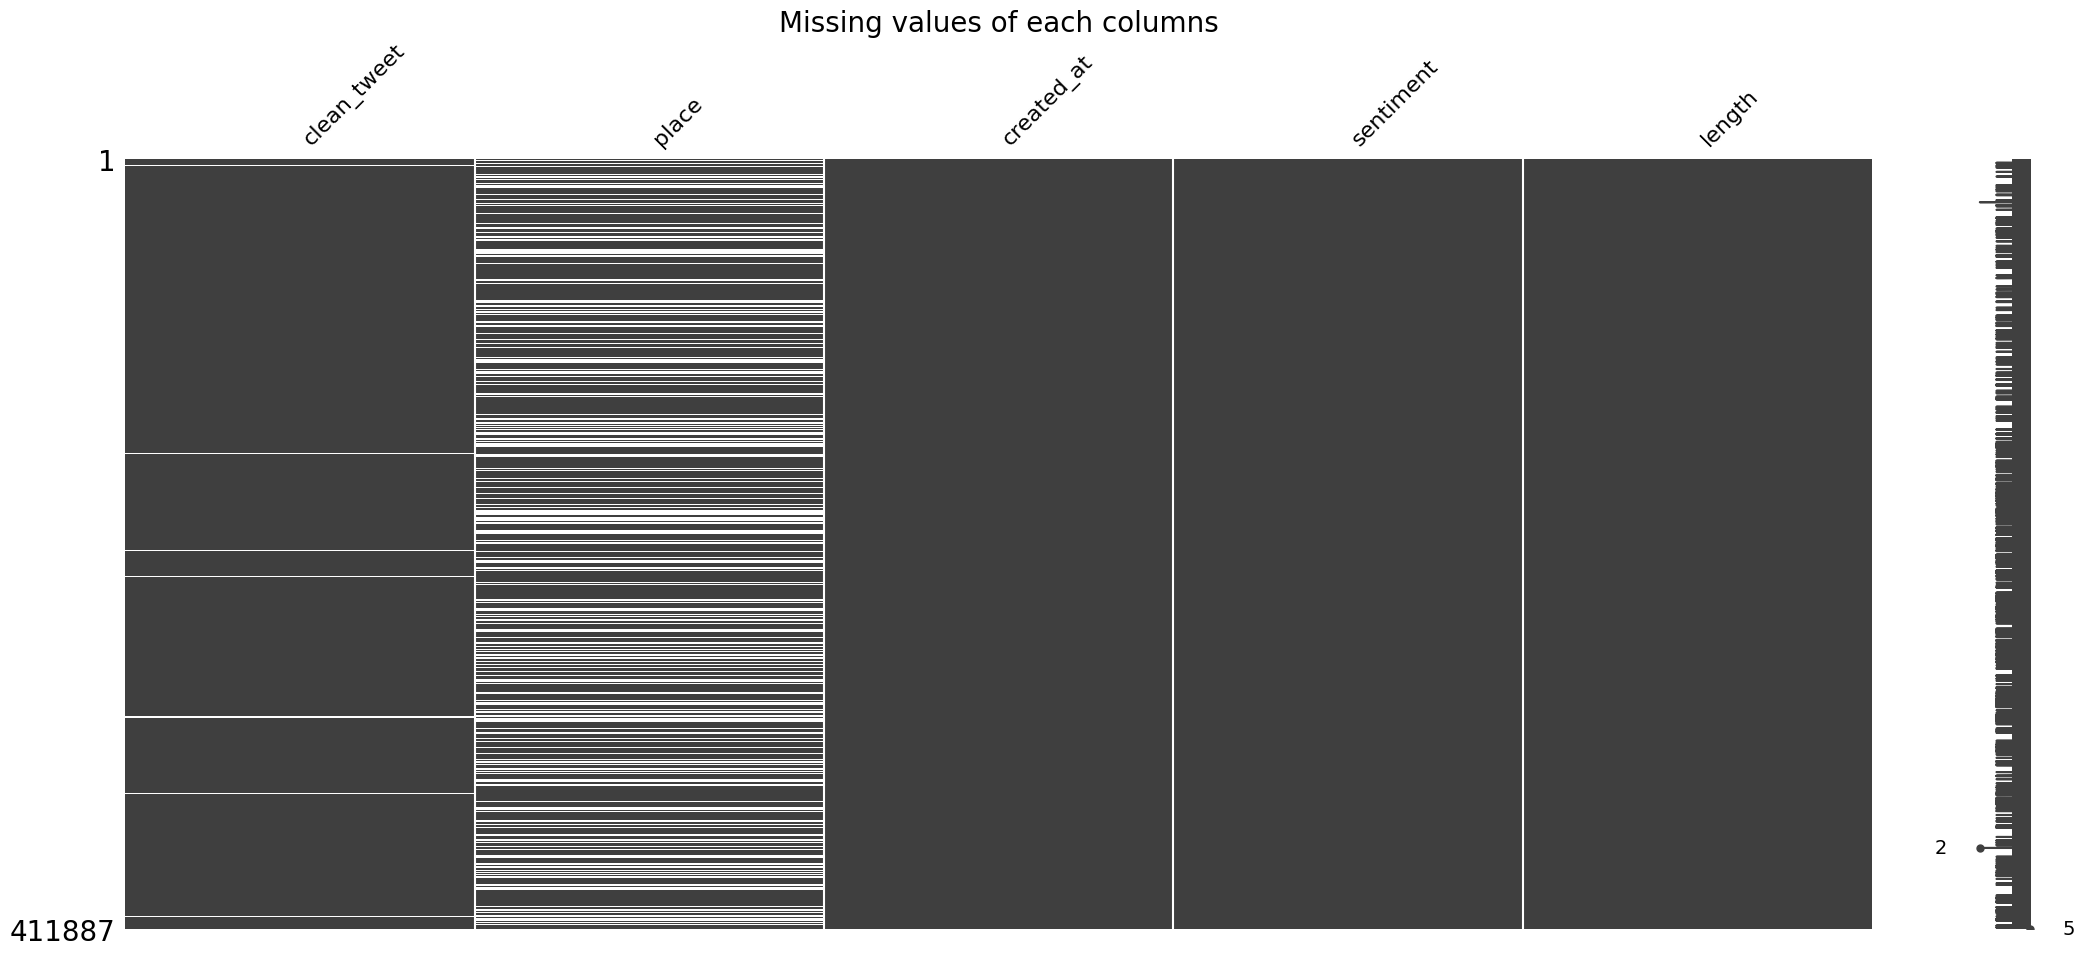

In [ ]:
msno.matrix(df)
plt.title('Missing values of each columns',fontsize=20)

可以看到place有缺失值

# 2. Exploring each columns (univariate analysis)

Text(0.5, 1.0, 'Monthly distribution of tweets')

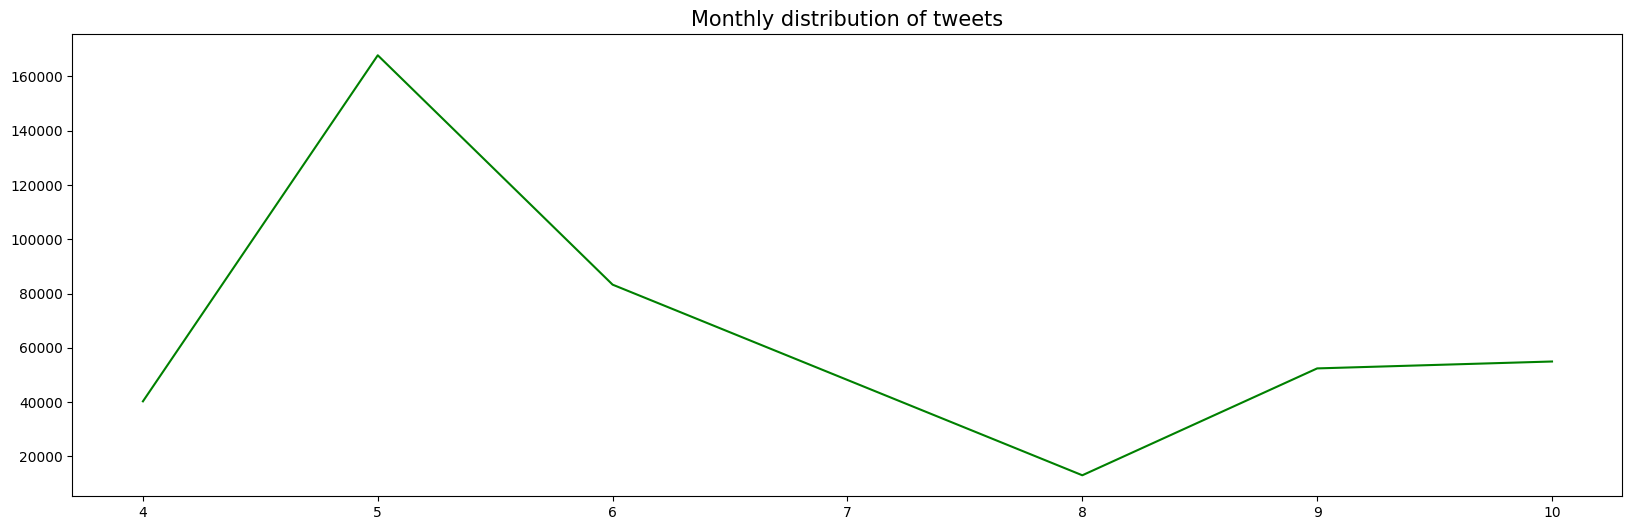

In [ ]:
time = df.groupby(['created_at']).size()
monthly = df['created_at'].dt.month.value_counts().sort_index()
plt.figure(figsize=(20,6))
sns.lineplot(x=monthly.index, y = monthly.values, color='green')
plt.title('Monthly distribution of tweets', fontsize=15)

data大部分分布在五月，接下來印出每天的分布

In [ ]:
fig = px.line(df,
              x=time.index,
              y=time.values,
              title = 'date of tweets',
              template='simple_white')

fig.update_layout(
    xaxis_title = 'Dates',
    yaxis_title = 'Count of Tweets',
    font=dict(size=17,family="Times New Roman"),)
fig.show()

2.2 place

In [ ]:
location = df['place'].value_counts()[:10]
fig = px.bar(x=location.index,y=location.values,text=location.values,
       color = location.index, color_discrete_sequence=px.colors.sequential.deep,
        title = 'Distribution of Top 10 Locations',
        template = 'simple_white')

fig.update_traces(textposition='inside',
                  textfont_size=11)

fig.update_layout(
    xaxis_title = 'Locations',
    yaxis_title = 'Count of Tweets',
    font=dict(size=17,family="Times New Roman"),)

fig.show()

美國和印度排名前二，倫敦和英格蘭則位居第三第四

2.3 sentiment

In [ ]:
sentiment = df["sentiment"].value_counts()
fig = px.pie(values=sentiment.values,
             names=sentiment.index,
             color_discrete_sequence=px.colors.sequential.Greens)
fig.update_traces(textposition='inside',
                  textfont_size=11,
                  textinfo='percent+label')
fig.update_layout(title_text="Category Pie Graph",
                  uniformtext_minsize=12,
                  uniformtext_mode='hide')

fig.show()

總共有三種情緒，pos正向 中性 負面

2.4 Tweet Length Distribution

In [ ]:
positive = df[df['sentiment'] == 'pos'].reset_index(drop=True)

neutral = df[df['sentiment'] == 'neu'].reset_index(drop=True)
negative = df[df['sentiment'] == 'neg'].reset_index(drop=True)

In [ ]:
hist_data = [positive['length'],neutral['length'], negative['length']]

group_labels = ['positive','neutral','negative']

colors = [ 'blue', 'lightblue','lightsalmon']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors = colors)

# Add title
fig.update_layout(title_text='Length distribution each sentiments', template = 'simple_white')
fig.show()

版本二

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd

In [ ]:
df['clean_tweet'].fillna('', inplace=True)

# Assuming 'df' is your DataFrame with a 'clean_tweet' column
text_data = df['clean_tweet'].astype(str)

# Combine CountVectorizer and TfidfTransformer for feature extraction
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(text_data)

In [ ]:
print(X.shape)

(411887, 2000)


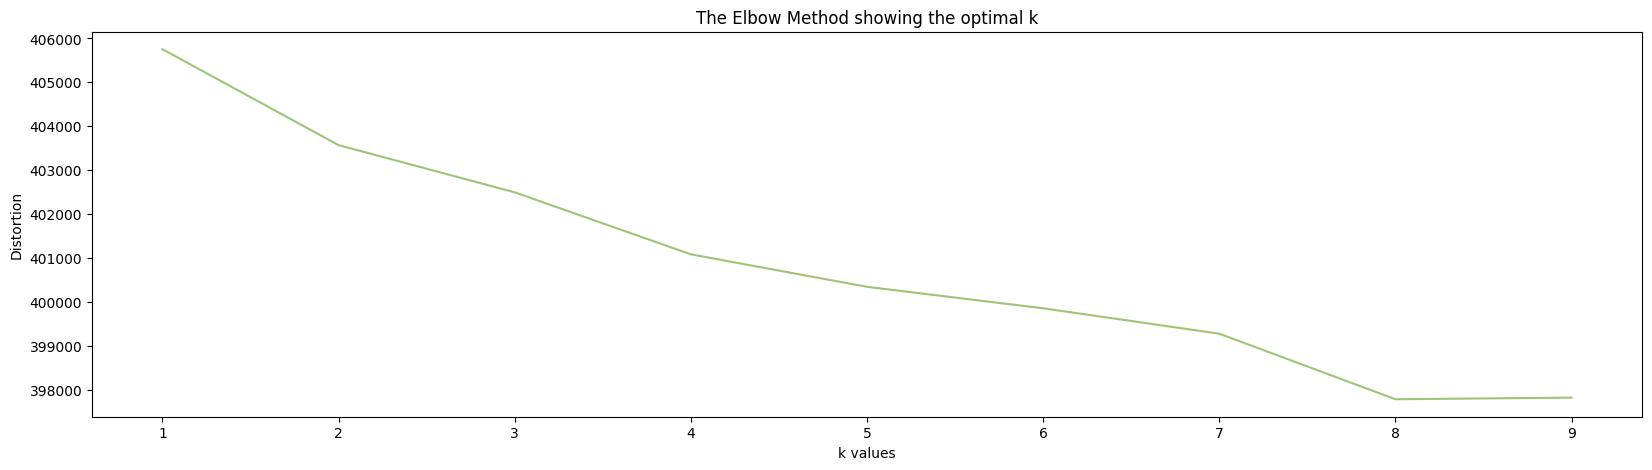

In [ ]:
distortions = []
K = range(1,10)
for k in K:
    kmean = KMeans(n_clusters=k,random_state=7)
    kmean.fit(X)
    distortions.append(kmean.inertia_)

plt.figure(figsize=(20,5))
plt.plot(K, distortions, '-',color='g')
plt.xlabel('k values')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
# Use K-means clustering
kmeans = KMeans(n_clusters=8, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

In [ ]:
# 顯示每個簇的數量
print(df['cluster'].value_counts())

0    150008
6    146844
7     30932
4     23677
2     21598
5     20749
3     10809
1      7270
Name: cluster, dtype: int64


In [ ]:
from sklearn.decomposition import IncrementalPCA
from tqdm import tqdm


# 創建 IncrementalPCA 實例
inc_pca = IncrementalPCA(n_components=2)

# 逐批次進行 PCA 並顯示進度條
batch_size = 1000
num_batches = X.shape[0] // batch_size + 1

# 初始化結果矩陣
X_pca = np.zeros((X.shape[0], 2))

for i in tqdm(range(num_batches), desc="PCA Progress"):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, X.shape[0])
    X_batch = X[start_idx:end_idx, :].toarray()

    # 在每個批次上進行擬合
    inc_pca.partial_fit(X_batch)

    # 同時進行 transform
    X_pca[start_idx:end_idx, :] = inc_pca.transform(X_batch)

PCA Progress: 100%|██████████| 412/412 [29:02<00:00,  4.23s/it]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

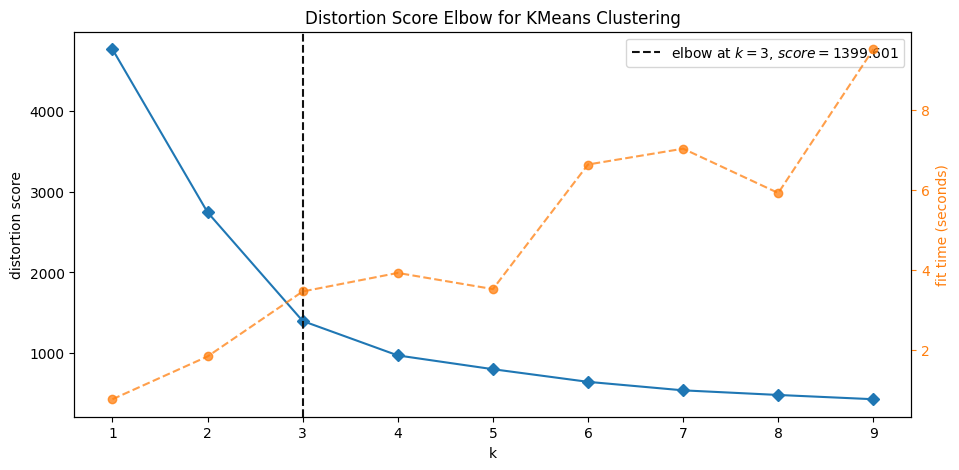

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(1,10),size=(1080, 500))

visualizer.fit(X_pca)
visualizer.show()

In [ ]:
# Use K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



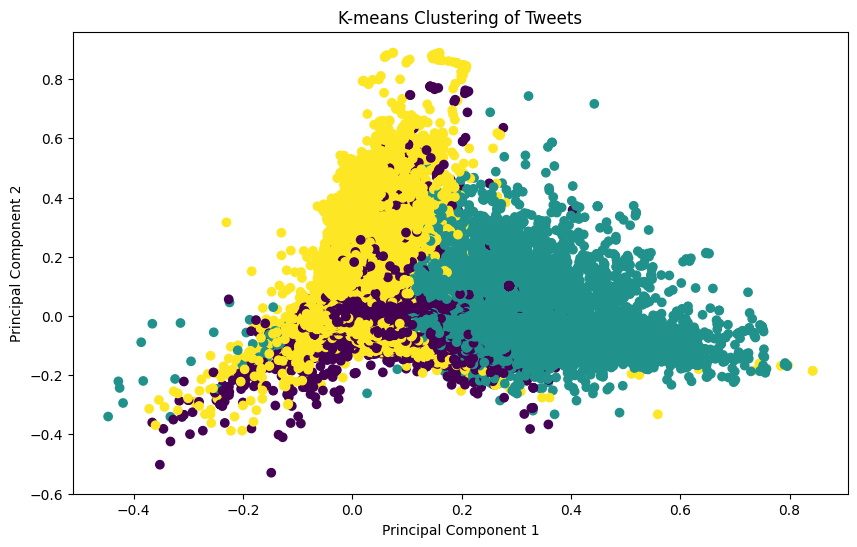

In [ ]:
# # 將 K-means 聚類結果繪製在散點圖上
# plt.figure(figsize=(10, 6))
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis')
# plt.title('K-means Clustering of Tweets')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

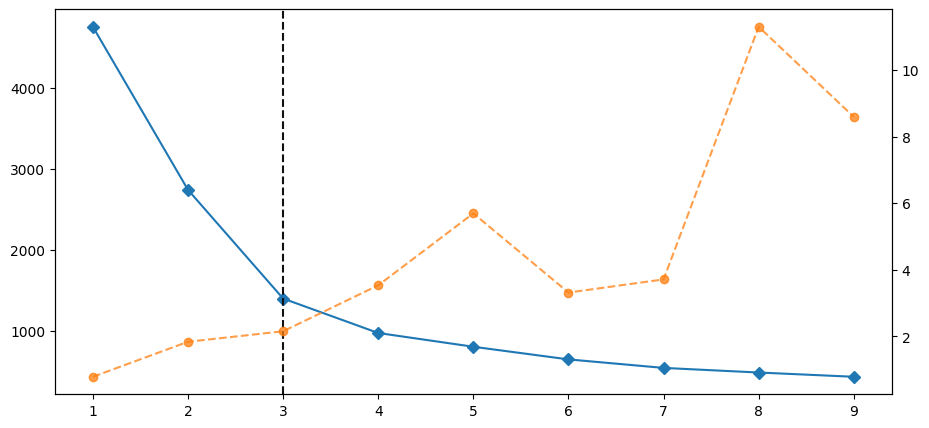

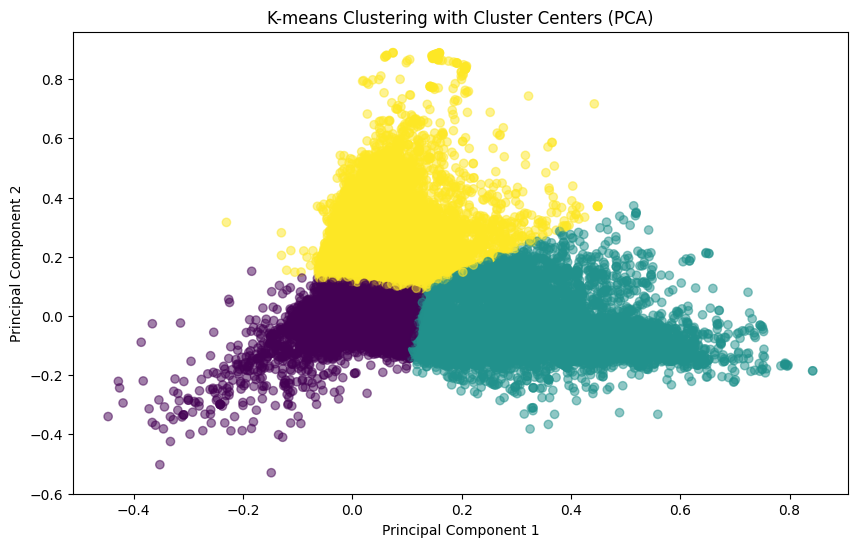

In [ ]:
# 重新適配 K-means 模型
visualizer_pca = KElbowVisualizer(KMeans(), k=(1, 10), size=(1080, 500))
visualizer_pca.fit(X_pca)  # 使用 PCA 後的資料進行擬合
optimal_k_pca = visualizer_pca.elbow_value_  # 取得 PCA 後的最佳聚類數目

# 使用 PCA 後的最佳聚類數目重新適配 K-means 模型
kmeans_pca = KMeans(n_clusters=optimal_k_pca, random_state=42)
df['cluster_pca'] = kmeans_pca.fit_predict(X_pca)

# 繪製 K-means 聚類和每個聚類中心（使用 PCA 後的資料）
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster_pca'], cmap='viridis', alpha=0.5)
plt.title('K-means Clustering with Cluster Centers (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [ ]:
# 顯示每個簇的數量
print(df['cluster'].value_counts())

0    193251
2    192310
1     26326
Name: cluster, dtype: int64



Top words for Cluster 0:
covid19    185983
vaccin      34669
peopl       21222
pandem      17406
new         16689
get         13980
health      13503
say         13176
trump       12056
one         11904
dtype: int64

Top words for Cluster 1:
case       25155
covid19    23422
new        13687
death      11246
report      8018
total       3839
confirm     3496
number      3087
updat       2741
day         2735
dtype: int64

Top words for Cluster 2:
test       23732
covid19    16956
posit      10018
peopl       1651
get         1440
new         1305
case        1211
day         1140
neg         1118
result      1029
dtype: int64


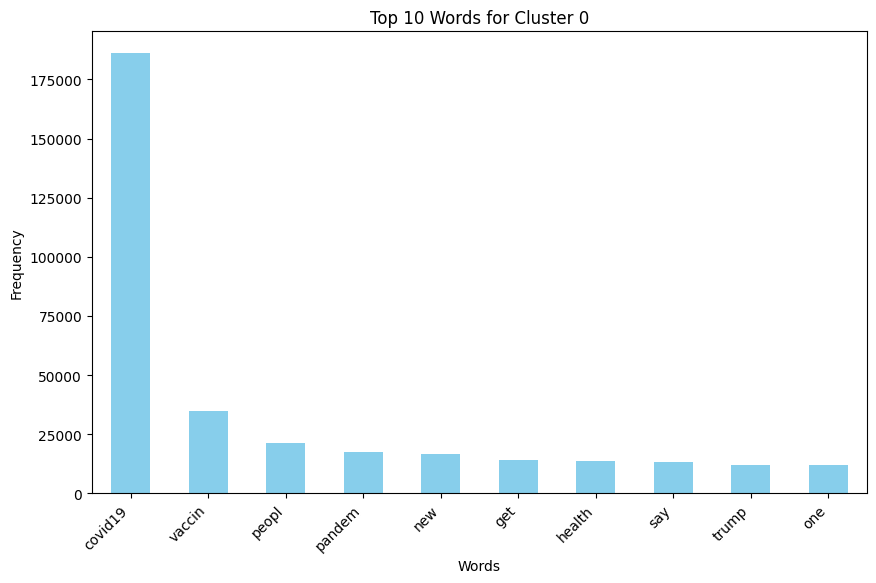

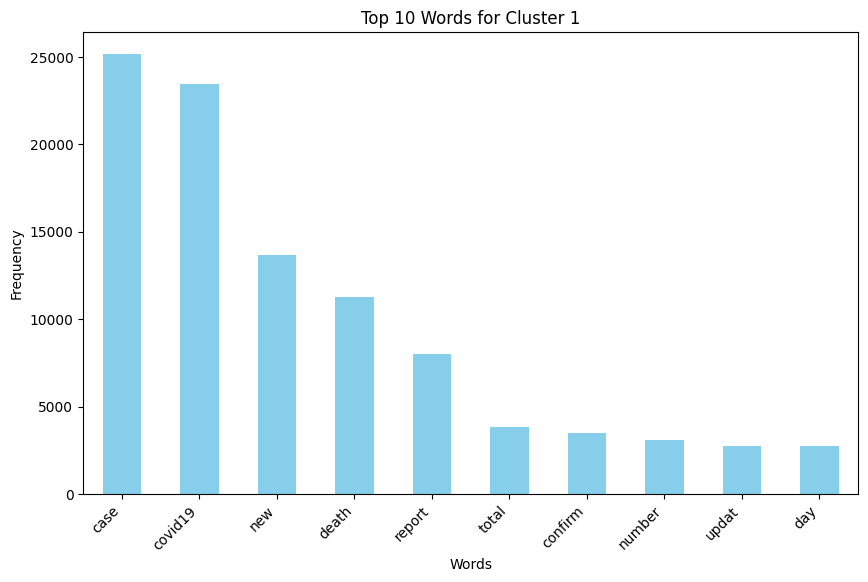

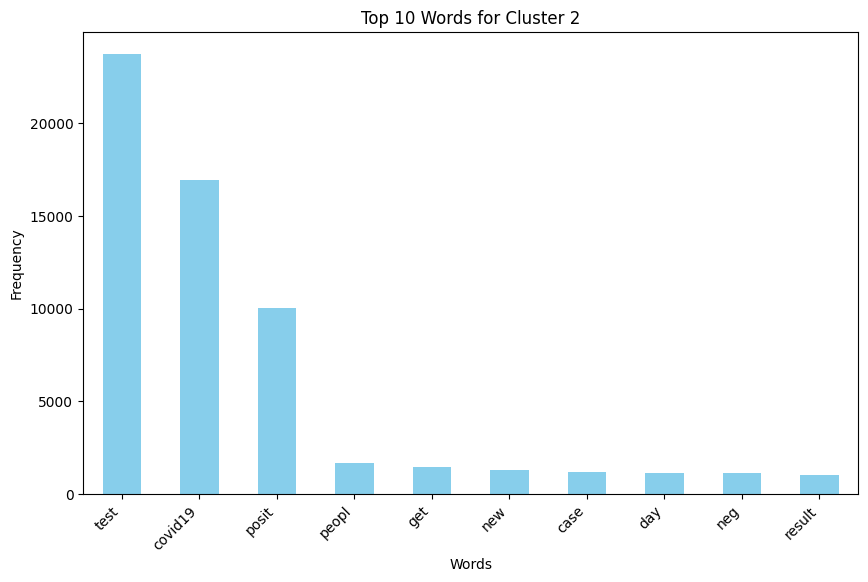

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# 假設 df 包含 'clean_tweet' 和 'cluster_pca' 欄位
df['clean_tweet'] = df['clean_tweet'].astype(str)

# 以 'cluster_pca' 分組，對每個群體進行文字統計
cluster_word_counts = df.groupby('cluster_pca')['clean_tweet'].apply(lambda x: ' '.join(x)).reset_index()

# 使用 CountVectorizer 來計算詞頻
vectorizer = CountVectorizer(max_features=1000)
X_cluster = vectorizer.fit_transform(cluster_word_counts['clean_tweet'])

# 取得詞彙
feature_names = vectorizer.get_feature_names_out()

# 建立 DataFrame，顯示每個群體中前 10 個最常見的字
top_words_df = pd.DataFrame(data=X_cluster.toarray(), columns=feature_names)
top_words_df['cluster_pca'] = cluster_word_counts['cluster_pca']

# 顯示每個群體中前 10 個最常見的字
for cluster_pca in top_words_df['cluster_pca'].unique():
    top_words_cluster = top_words_df[top_words_df['cluster_pca'] == cluster_pca].sum().drop('cluster_pca').sort_values(ascending=False).head(10)
    print(f"\nTop words for Cluster {cluster_pca}:\n{top_words_cluster}")

# 設定每個群體中前 n 個字的數量
n = 10

# 顯示每個群體中前 n 個最常見的字的長條圖
for cluster_pca in top_words_df['cluster_pca'].unique():
    top_words_cluster = top_words_df[top_words_df['cluster_pca'] == cluster_pca].sum().drop('cluster_pca').sort_values(ascending=False).head(n)

    # 繪製長條圖
    plt.figure(figsize=(10, 6))
    top_words_cluster.plot(kind='bar', color='skyblue')
    plt.title(f'Top {n} Words for Cluster {cluster_pca}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.show()

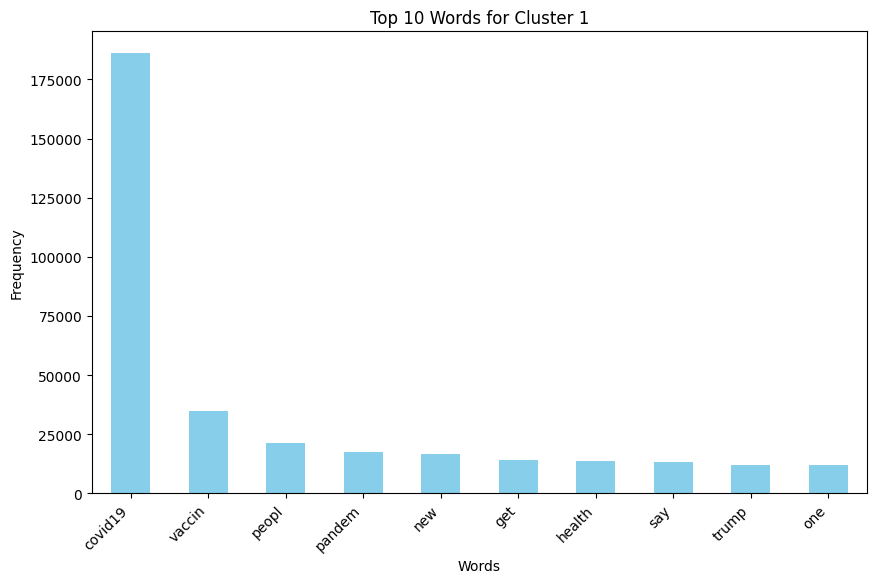

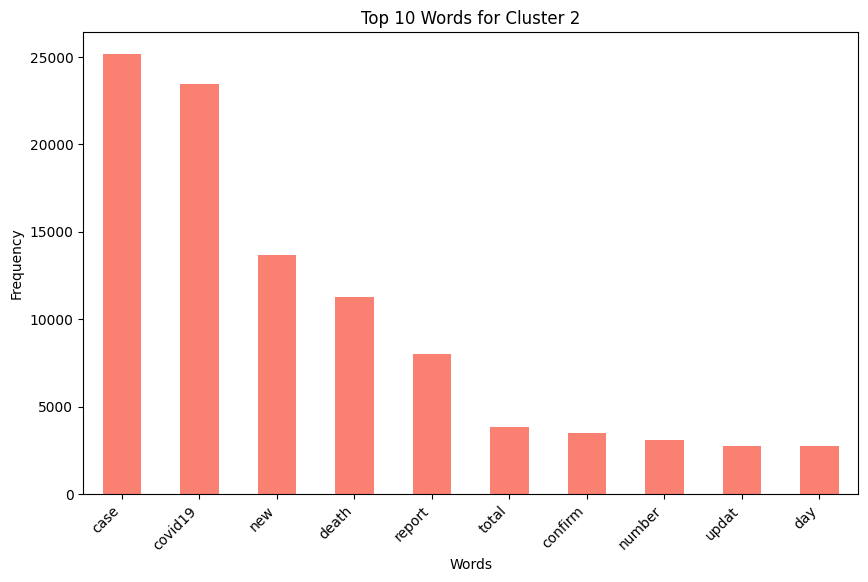

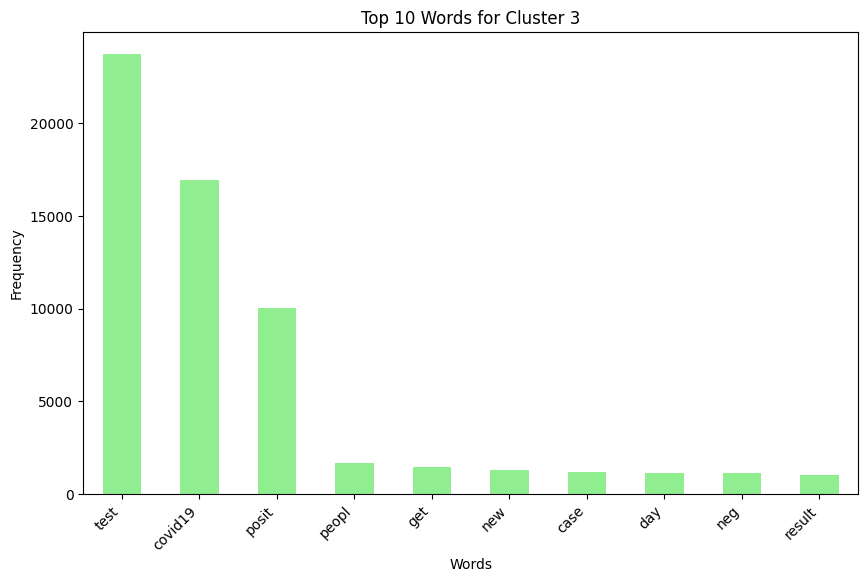

In [ ]:
import matplotlib.pyplot as plt

# 設定每個群體中前 n 個字的數量
n = 10

# 定義一個色彩列表，每個群體一個顏色
colors = ['skyblue', 'salmon', 'lightgreen', 'gold', 'lightcoral', 'cornflowerblue', 'lightpink', 'mediumseagreen', 'lightsteelblue']

# 顯示每個群體中前 n 個最常見的字的長條圖
for i, cluster_pca in enumerate(top_words_df['cluster_pca'].unique()):
    top_words_cluster = top_words_df[top_words_df['cluster_pca'] == cluster_pca].sum().drop('cluster_pca').sort_values(ascending=False).head(n)

    # 繪製長條圖，指定顏色
    plt.figure(figsize=(10, 6))
    top_words_cluster.plot(kind='bar', color=colors[i])
    plt.title(f'Top {n} Words for Cluster {cluster_pca + 1}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.show()
